# Handwritten Digit Classfication using LSTM

In this example, we are going to use the MNIST dataset to train a multi-layer feed foward neural network. MNIST is a simple computer vision dataset of handwritten digits. It has 60,000 training examles and 10,000 test examples. "It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting." For more details, please checkout the website [MNIST](http://yann.lecun.com/exdb/mnist/).

In [1]:
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from utils import get_mnist

init_engine()

Populating the interactive namespace from numpy and matplotlib


## 1. Load MNIST dataset

Please edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory.

In [2]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

train_data = train_data.map(lambda s: Sample.from_ndarray(np.resize(s.features.to_ndarray(), (28, 28)), s.label.to_ndarray()))
test_data = test_data.map(lambda s: Sample.from_ndarray(np.resize(s.features.to_ndarray(), (28, 28)), s.label.to_ndarray()))
print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


## 2. LSTM Model Setup

This time we will use another recurrent neural network called LSTM to classify handwritten digits. You can checkout this [blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) to get a detailed understanding of recurrent neural networks and LSTMs in particular.

In [3]:
# Parameters
batch_size = 64

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

In [4]:
def build_model(input_size, hidden_size, output_size):
    model = Sequential()
    recurrent = Recurrent()
    recurrent.add(LSTM(input_size, hidden_size))
    model.add(InferReshape([-1, input_size], True))
    model.add(recurrent)
    model.add(Select(2, -1))
    model.add(Linear(hidden_size, output_size))
    return model
rnn_model = build_model(n_input, n_hidden, n_classes)

creating: createSequential
creating: createRecurrent
creating: createLSTM
creating: createInferReshape
creating: createSelect
creating: createLinear


## 3. Optimizer Setup

In [5]:
# Create an Optimizer

#criterion = TimeDistributedCriterion(CrossEntropyCriterion())
criterion = CrossEntropyCriterion()
optimizer = Optimizer(
    model=rnn_model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(),
    end_trigger=MaxEpoch(5),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='rnn-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to ",app_name

creating: createCrossEntropyCriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  rnn-20170720-151955


In [6]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 40 ms, sys: 12 ms, total: 52 ms
Wall time: 11min 4s


In [7]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

Ground Truth labels:
7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 3.23 s


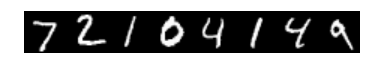

In [8]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features.to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))

## 4. Draw the performance curve

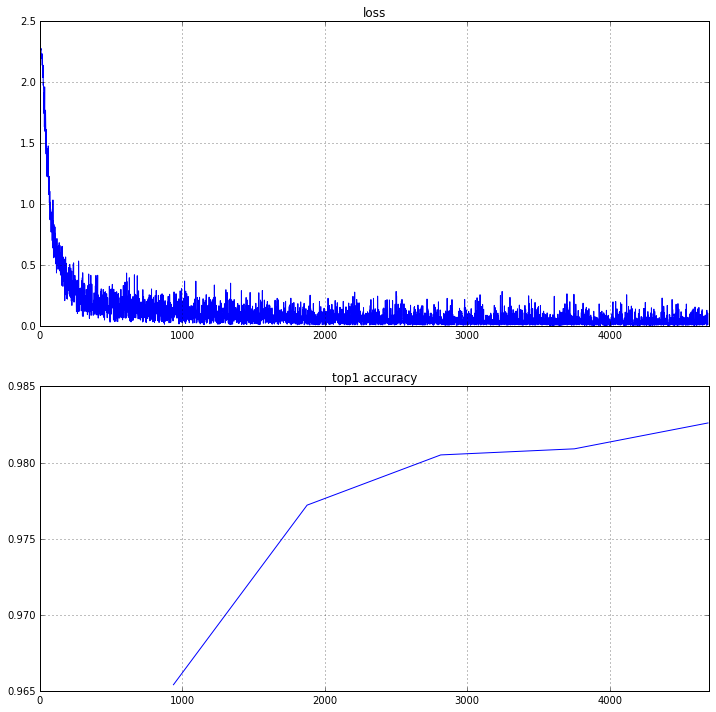

In [9]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)